# Introduction
This tutorial will give an example application of using deep learning for medical image segmentation. This example will demonstrate how to train a convolutional neural network for the purpose of lung segmentation in CT images. The tutorial will have 3 main parts:
1. Loading and preparing data for model training
2. Creating, training, and evaluating a deep learning segmentation model
3. Making improvements to the model with skip connections

Keep an eye out for questions through this demo to test your new DL knowledge and critical thinking. There are answers at the end of the document.

### Initial preparation

These are some modules that we will definitely need throughout this example.

In [1]:
import os # operating system operations 
import numpy as np # number crunching
np.random.seed(1) # set seed for random number generator
import keras # our deep learning library
import matplotlib.pyplot as plt # for plotting our results
# set plotting to be in-line and interactive
%matplotlib notebook

import GPUtil
if not 'DEVICE_ID' in locals():
    DEVICE_ID = GPUtil.getFirstAvailable()[0]
    print('Using GPU',DEVICE_ID)
os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_ID)

Using TensorFlow backend.


Using GPU 1


We will import other necessary modules as we go and need them

# Part 1: Data Preparation
All deep learning applications start with getting the data. In this case, the data has already been collected from subjects through CT scans and annotations have been made. 
Now that all the data is available, we need to load in this data in an organized way and get it ready to feed into a deep learning model for training.
We already have the data downloaded and extracted to the sub-directory 'LCTSC' in your working directory, so we can dive right in.

### Directory setup

In [2]:
# First, let's get all the subject directories. We'll do this by proceeding
# through the directory structure and grabbing the ones we want.
# We'll use the package glob to make this easy
import glob
# We know our initial directory: LCTSC. Let's add that to our current
# directory to get the full path
initial_dir = os.path.join(os.getcwd(),'LCTSC')
# Now we'll get all the subject directories using glob
subj_dirs = glob.glob(os.path.join(initial_dir,'LCTSC*'))
# Now all the subject directories are contained in a list
# Let's grab the first one in that list and look for the data
cur_dir = subj_dirs[1]
# The next directory level just has 1 directory, so we'll grab that
cur_dir = glob.glob(os.path.join(cur_dir, "*", ""))[0]
# Now we have the dicom image directory and the label directory
# The dicom iamge directory starts with a 0 so we'll find that one first
dcm_dir = glob.glob(os.path.join(cur_dir, "0*", ""))[0]
# Let's grab the label directory while we're at it. It starts with a 1
lbl_dir = glob.glob(os.path.join(cur_dir, "1*", ""))[0]
# Now, we can get the list of dicom files that we need to 
# load for this subject
# We just have to look for .dcm files in the dcm_dir we found
dicom_files = glob.glob(os.path.join(dcm_dir, "*.dcm"))
# Great. Let's get the label filepath too
# It's just contained in a single dicom-rt file in the label directory
lbl_file = glob.glob(os.path.join(lbl_dir,"*.dcm"))[0]

Great! We have all the file paths for this subject. Now we need to actually load in the data

### Reading in images

In [3]:
# We'll need the PyDicom package to read the dicoms
import pydicom
# First, we'll load in all the dicom data to a list
dicms = [pydicom.read_file(fn) for fn in dicom_files]
# These likely won't be in slice order, so we'll need to sort them
# using the ImagePositionPatient header tag
dicms.sort(key = lambda x: float(x.ImagePositionPatient[2]))
# Then, stack all the pixel data together into a 3D array
# We'll convert the data from integers to floats while doing this
ims = np.stack([dcm.pixel_array.astype(np.float) for dcm in dicms])
# The last thing we will do is normalize all the images
# There are a variety of normalization methods used. This one
# is pretty common
for im in ims:
    im -= np.mean(im)
    im /= np.std(im)

##### Question 1: What other choices could we make for input image normalization?

### Reading in segmentation masks
We just loaded the input data for our deep learning model. Now we need to create the target masks that we want to train our model to output.

We want our output to be in the form of a binary mask- 1's where the pixels are part of the region of interest, and 0's where they are not.
Unfortunately, the data we have came from a segmentation program where it was stored as contours- the boundaries of the region of interest.

We will have to load in the contour data and convert it into the masks we need.

The data we have actually has contours for the heart, lungs, spine, and esophagus. For the purpose of this example, we will focus on the lungs.

In [4]:
# Let's go back and load the label file we already found
label = pydicom.read_file(lbl_file)
# First, get the contour data.
# We need to figure out which contours are the lungs
contour_names = [s.ROIName for s in label.StructureSetROISequence]
# Get the right and left lung indices
r_ind = contour_names.index('Lung_R')
l_ind = contour_names.index('Lung_L')
# Extract the corresponding contours and combine
contour_right = [s.ContourData for s in 
                 label.ROIContourSequence[r_ind].ContourSequence]
contour_left = [s.ContourData for s in 
                label.ROIContourSequence[l_ind].ContourSequence]
contours = contour_left + contour_right
# Next, we need to setup the coordinate system for our images
# to make sure our contours are aligned
# First, the z position
z = [d.ImagePositionPatient[2] for d in dicms]
# Now the rows and columns
# We need both the position of the origin and the
# spacing between voxels
pos_r = dicms[0].ImagePositionPatient[1]
spacing_r = dicms[0].PixelSpacing[1]
pos_c = dicms[0].ImagePositionPatient[0]
spacing_c = dicms[0].PixelSpacing[0]
# Now we are ready to create our mask
# First, preallocate an array of zeros
mask = np.zeros_like(ims)    
# we are going to need a contour-to-mask converter
from skimage.draw import polygon
# now loop over the different slices that each contour is on
for c in contours:
    nodes = np.array(c).reshape((-1, 3))
    assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
    zNew = [round(elem,1) for elem in z]
    try:
        z_index = z.index(nodes[0,2])
    except ValueError:
        z_index = zNew.index(nodes[0,2])
    r = (nodes[:, 1] - pos_r) / spacing_r
    c = (nodes[:, 0] - pos_c) / spacing_c
    rr, cc = polygon(r, c)
    mask[z_index,rr, cc] = 1

### Now we have a mask!

We have all the pieces we need:
* Inputs
* Targets

...but just for the first subject out of ten. Now we just to repeat for all of the subjects.

Luckily, we have provided a pre-made function that does everything we just did in one move. All we have to do is call this function on each of the directories we already collected

In [5]:
# function for loading in input and target data given a directory
from Demo_Functions import GetLCTSCdata

Now, apply this function to each subject directory.

This will take a little bit to run.

In [6]:
data = [GetLCTSCdata(d) for d in subj_dirs]
# get all images together as inputs
inputs = np.concatenate([d[0] for d in data])
# get all masks together as targets
targets = np.concatenate([d[1] for d in data])
# clear a couple large variables that are no longer needed
del data

At this point, it would be good to check that our data loaded correctly and the masks correspond to the input images. We'll using the python plotting package matplotlib to display a sample image and mask side by side.

<IPython.core.display.Javascript object>


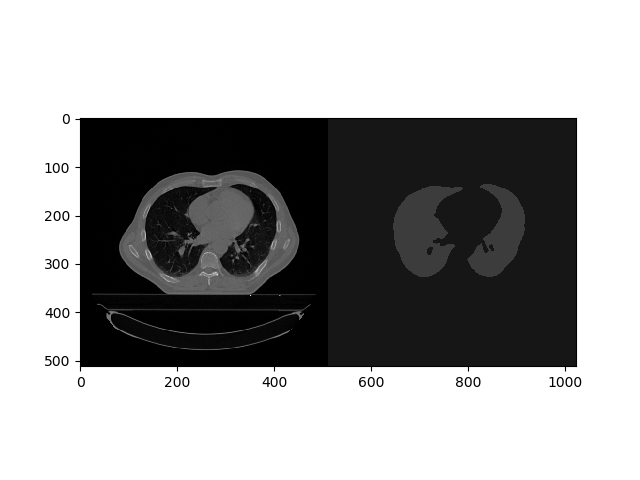

In [7]:
disp_ind = 50
plt.figure()
disp = np.c_[inputs[disp_ind,...],
             targets[disp_ind,...]]
plt.imshow(disp,cmap='gray')
plt.show()

Looks good!

### Final pre-processing

Just a couple more pre-processing steps.
First, our images are 512x512. That's pretty large for most deep learning applications. It's certainly doable, but for the purpose of this demonstration we will downsample to 256x256 so that the processing is faster.

We'll use another scikit-image function for this. It will also take a little bit to run.

In [8]:
from skimage.transform import resize
inputs_rs = np.zeros((inputs.shape[0],256,256))
for i,im in enumerate(inputs):
    inputs_rs[i] = resize(im,(256,256))
targets_rs = np.zeros((targets.shape[0],256,256))
for i,im in enumerate(targets):
    targets_rs[i] = resize(im,(256,256))
    
inputs = inputs_rs
targets = targets_rs
del inputs_rs, targets_rs

/home/jmj136/.conda/envs/tf_keras/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jmj136/.conda/envs/tf_keras/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


The final step is to add a singleton dimesion to these arrays. This is necessary because the deep learning model we will create will expect our input to have color channels. Since our images are grayscale, they will just have a single "color" channel.

In [9]:
# add a singleton dimension to the input and target arrays
inputs = inputs[...,np.newaxis]
targets = targets[...,np.newaxis]

##### Question: What could be another use for having multiple input channels?
Hint: Think MRI.

## Our data is now ready for training!

### Wait.

We don't just need training data. We need a way of determining if our model is overfitting. This means we need both training data and also another set of data to check the performance on data that is not being trained on. 

We can split some of our data off and use it for validation during the training process. Let's take 10% of the first slices and use them for this purpose. This will be equal to the first subject, so we won't have any overlap of subjects between the different sets

In [10]:
# Get the total number of slices
num_slices = inputs.shape[0]
# Find the cutoff- set to 90% train and 10% validation
split_ind = np.int(.1*num_slices)
# split into training and validation sets using the cutoff
x_val = inputs[:split_ind]
y_val = targets[:split_ind]
x_train = inputs[split_ind:]
y_train = targets[split_ind:]
# finally, shuffle the order of the training data
# being sure to keep the inputs and targets in the 
# same order
sort_r = np.random.permutation(x_train.shape[0])
x_train = np.take(x_train,sort_r,axis=0)
y_train = np.take(y_train,sort_r,axis=0)

### NOW, our data is ready!

# Part 2: Building a segmentation network

We will build a deep convolutional neural network layer by layer, using Keras' high-level libraries that are relatively easy to work with to create exactly the network that we want.

For this segmentation problem, the most common and effective networks follow a style known as 'convolutional encoder-decoder' or CED. This means that using convolutional layers we will downsample, or 'encode', our input data, and then upsample, or 'encode' back to our original input size. In this way, the convolutional layers will learn to create a mapping of our input images into a segmentation mask.

Let's get to work!

We first need an input layer that takes our inputs

In [11]:
# import Input from keras layers
from keras.layers import Input

Our input layer just needs the shape of the input we are providing. The shape dimensions are [sample,row,column,channel].

For this 2D network, our samples are different slices. We don't need to provide this dimension to the input layer, since we will feed those samples in as batches during training. But we need the rest of the dimensions

In [12]:
# create our input layer by giving it an input shape
inp = Input(shape=x_train.shape[1:])

Now, we will add on convolutional layers

In [13]:
# import 2D convolution layer from keras layers
from keras.layers import Conv2D

The syntax for adding layers to our network is:

`newlayer = LayerType(layer_parameters)(input_layer)`

   newlayer: the variable that stores the current output of the network.  
   LayerType: the type of the new layer we are adding onto the network, in this case Conv2D layers.  
   layer_parameters: the inputs we provide to define the new layer. For Conv2D layers, this is given as (number of filters, size of filters, and type of nonlinearity applied to the layer).  
   input_layer: the previous layer that our new layer is going to be connected to.
   
So for example: `x = Conv2D(10,(3,3), activation='relu')(inp)` creates a 2D convolutional layer with 10 filters that are 3x3 in size. The non-linearity (activation) is a Rectified Linear Unit, and it takes 'inp' as an input and gives its output as x.

One final note before we build the model. The filters (or 'kernels') are intialized in the background by some random distribution before training. Different distributions can greatly affect how quickly the model learns, or whether it converges at all. Each task can require different intialization distributions and usually requires playing around with different options. For the models we are using today, we already did this work for you and found that the He Normal distribution is most effective (He et al., http://arxiv.org/abs/1502.01852). We will set this parameter in all the convolutional layers.

In [14]:
init = 'he_normal'

Without further ado, let's make a convolutional neural network!

In [15]:
# Make the first convolutional layer with 10 filters, 3x3 filter size,
# ReLU activation, and set kernel_initializer to init as defined above
x = Conv2D(10,(3,3),activation='relu',kernel_initializer=init)(inp)
# Make 2 more convolutional layers connected in order. Increase the filter
# number for each
x = Conv2D(20,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2D(30,(3,3),activation='relu',kernel_initializer=init)(x)
# now we will use a strided convolution, which downsamples the input
# and increases the network's receptive field. This is part of the
# encoding side of the network.
x = Conv2D(40,(4,4),strides=(2,2),activation='relu',kernel_initializer=init)(x)
# repeat that sequence
x = Conv2D(50,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2D(60,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2D(70,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2D(80,(4,4),strides=(2,2),activation='relu',kernel_initializer=init)(x)
# now, we will reverse the downsampling using Transposed Convolutions, also
# incorrectly but commonly called Deconvolution
# This is now the decoding side of the network
# Import 2D Transpose Convolution from keras layers
from keras.layers import Conv2DTranspose
# The syntax is identical. However, we need the decoding side of the network to end
# up with the same output size as our images. To do that, the first Transpose layer 
# we will add will have some padding. Simply add the parameter like this:
# padding='same'
x = Conv2DTranspose(70,(3,3),activation='relu',kernel_initializer=init,padding='same')(x)
# Now add another regular layer (no padding) and a strided layer
x = Conv2DTranspose(60,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2DTranspose(50,(4,4),strides=(2,2),activation='relu',kernel_initializer=init)(x)
# Repeat that sequence, but no padding this time
x = Conv2DTranspose(40,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2DTranspose(30,(3,3),activation='relu',kernel_initializer=init)(x)
x = Conv2DTranspose(20,(4,4),strides=(2,2),activation='relu',kernel_initializer=init)(x)
# Just one more transpose layer to get the sizing right
x = Conv2DTranspose(10,(3,3),activation='relu',kernel_initializer=init)(x)
# Finally, our output layer will need to have a single output
# channel corresponding to a single segmentation class
# Use sigmoid activation to squash the output to a probability, and
# use a 1x1 filter to not change the output size
out = Conv2D(1,(1,1),activation='sigmoid',kernel_initializer=init)(x)
# Now, we have a graph of layers created but they are not yet a model
# Fortunately, Keras makes it easy to make a model out of a graph
# just using the input and output layers
# Import Model from keras models
from keras.models import Model
# define our segmentation model using Model
SegModel = Model(inp,out)

We have a deep learning model created! Let's take a look to make sure we got the image shapes to work out:

In [16]:
# Print a summary of the model we just made
SegModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 10)      100       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 20)      1820      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 250, 250, 30)      5430      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 40)      19240     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 50)      18050     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 120, 60)      27060     
__________

### Compiling the model

Compiling the model is the final step before it is ready to train. We need to define our loss function and optimizer that Keras will use to run the training. In this step, Keras will also randomly initialize the weights of our network- so every time the network is trained, it has a different starting point and it is possible to get different results.

### Loss function
The Dice coefficient is not only a good segmentation metric, is also works well as a segmentation loss function since it can be converted to being differentiable without much difficulty. Loss functions in Keras need be defined using tensor functions, using the backend API.

Here is what that looks like:

In [17]:
import keras.backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1)/(K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    # We have calculated dice, but we want to maximize it. 
    # Keras tries to minimize the loss so we simply return 1- dice
    return 1-dice

### Optimizer
There are many different optimizers that Keras allows us to use without much trouble. We have provided two examples here and you can try both to see how well they help the model train.

Segmentation can be tricky- if you don't have enough data, the model might not converge. We are working with a limited amount of data so that is a possible issue. We have already experimented for you to find parameters that work well for this model. We found that SGD- Stochastic Gradient Descent- works best here. We set a low learning rate and some learning rate decay. We also use Nesterov momentum, which is rarely a bad idea for SGD.
The final other parameter we'll use is setting the clipnorm, which means the gradients during training will be clipped to a fixed value. This prevents an issue know as "exploding gradients" which causes the model to stop learning.

##### Challenge: 
Experiement with these different settings and see if you can find an optimizer and combination of parameters that gets better results in the same amount of training (epochs)

In [18]:
# Setup a SGD optimizer with learning rate of 0.05, decay of 1e-6, momentum of .9
# Nesterov momentum enabled, and clipnorm set to 0.5
opt = keras.optimizers.SGD(lr=0.05,decay=1e-6,momentum=.9,nesterov=True,clipnorm=0.5)
# Compile the segmentation model with Dice as the loss and the created optimizer
SegModel.compile(loss=dice_coef,optimizer=opt)

### Model Training
All that's left to do is to "fit" the model to our data! 

Keras takes a few more parameters during model "fitting" (training):
* Our training data (obviously)
* Batch size- how many samples are fed in at once
* Epochs- how many times to go through all training data
* We ask Keras to constantly report progress (verbose)
* Shuffle set to True so the data is in random order for every epoch
* Our validation data that will be evaluated at the end of every epoch so we can keep an eye on overfitting

In [19]:
# Run the model training with our x and y training data, batch size of 32,
# 7 epochs, shuffle on, and provide our validation data
# Save the output to the variable 'hist'
hist = SegModel.fit(x_train, y_train,
          batch_size=32,
          epochs=7,
          verbose=1,
          shuffle=True,
          validation_data=(x_val, y_val))

Train on 1299 samples, validate on 144 samples
Epoch 1/7
1299/1299 [==============================] - 18s 14ms/step - loss: 0.9216 - val_loss: 0.9369
Epoch 2/7
1299/1299 [==============================] - 12s 10ms/step - loss: 0.8733 - val_loss: 0.7077
Epoch 3/7
1299/1299 [==============================] - 11s 9ms/step - loss: 0.3774 - val_loss: 0.4967
Epoch 4/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.1836 - val_loss: 0.4228
Epoch 5/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.1304 - val_loss: 0.3862
Epoch 6/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.1107 - val_loss: 0.3600
Epoch 7/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.0833 - val_loss: 0.3493


### Evaluate Model
After the training is complete, we evaluate the model again on our validation data to see the results.

In [20]:
# Get the Dice score from evaluating the model and print it out
score = SegModel.evaluate(x_val, y_val, verbose=0)
print('Final Dice on validation set: {:.04f}'.format(1-score))

Final Dice on validation set: 0.6507


Another way to evaluate a model is to look at how both the training and validation losses change during training. Keras gave us this data when we trained the model, now we can plot them together.

<IPython.core.display.Javascript object>


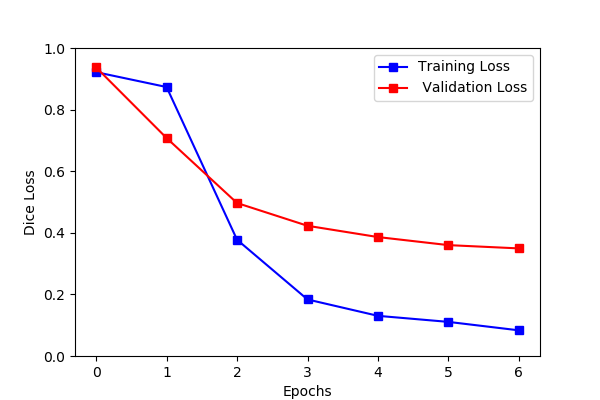

In [21]:
# Plot the losses that are stored in the 'hist' variable
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist.epoch,hist.history['loss'],'b-s')
plt.plot(hist.epoch,hist.history['val_loss'],'r-s')
plt.legend(['Training Loss',
            ' Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.ylim([0,1])
plt.show()

An important thing to look for is that the validation loss isn't increasing while the training loss decreases. The divergence of the losses like this means that the model is overfitting- it is getting really good at the training data that it sees, but it is getting worse at the data that it doesn't see. This means the model won't be very helpful when we want to apply it to new data.
Due to the random initialization of the network, the exact loss plots will be different every single time you train it. However, for this example, some general statements can be made that probably apply to your results.
* The validation and training losses generally go down. This is good- the model is learning.
* The validation loss is generally higher than the training loss. This is expected- the model will learn the training data best because that is what it gets direct feedback on. The hope is that it will transfer what it learns to the validation data too.
* The validation loss spikes up at some point. This is also pretty normal. The validation data isn't part of the feedback loop so it's not guaranteed that the model will consistently get better results on it. As long as the spikes are isolated and the validation loss follows a general downward trend, it's not anything to worry about.

##### Question 3: What techniques or strategies can be used to mitigate issues with overfitting?

Another useful way to evaluate a model is to just look at the outputs. We can look at a sample image to see how the mask looks compared to the ground truth.

In [22]:
# Get the predictions of the model on the validation inputs
predictions = SegModel.predict(x_val)

<IPython.core.display.Javascript object>


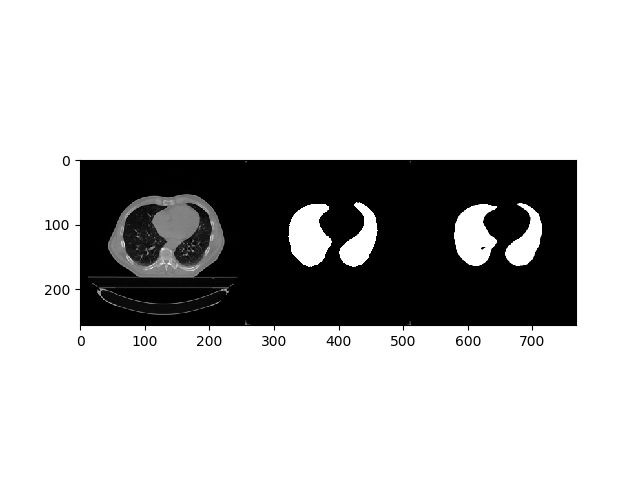

In [23]:
# pick a random slice to examine
disp_ind = 45
# get the CT image, the model predicted mask, and the target mask
image = x_val[disp_ind,...,0]
predicted_mask = predictions[disp_ind,...,0]
truth_mask = y_val[disp_ind,...,0]
# normalize image for display
image = image-np.min(image)
image = image/np.max(image)
# create a figure
plt.figure()
# combine images together into one
disp = np.c_[image,predicted_mask,truth_mask]
# display image
plt.imshow(disp,cmap='gray')
plt.show()

Results will vary here. It's unlikely that the model already learned a beautiful mask, but hopefully it at least learned something useful and can produce a somewhat reasonable result.

Sometimes it helps to get more precise visualization. We have provided a function for viewing the mask on top of the image, so we can maybe start to explain what mistakes the model is making.

<IPython.core.display.Javascript object>


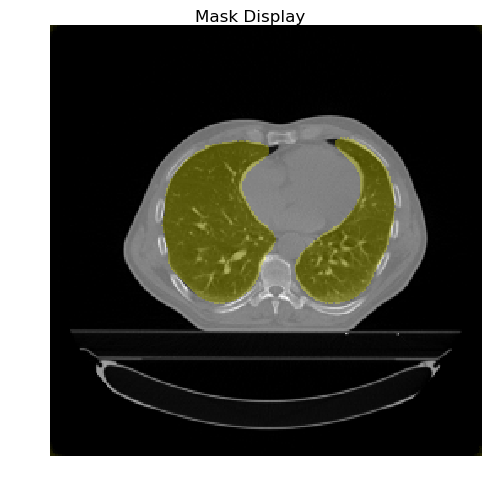

In [24]:
from Demo_Functions import display_mask

display_mask(image,predicted_mask)

##### Question 4: Can you explain the errors made by the deep learning model?

There are a variety of directions to go from here

A deeper net gives more representational power to the model. If the problem is too complex for the current network, making it deeper should improve performance.

Some mathematical tricks, like batch normalization and ELU activations can help with the learning process and make the model learn quicker.

Deep learning models are generally trained for much longer than how long we are running for this example.

In segmentation, a particularly useful trick is the use of skip connetions, in which layers from the downsampling part of the network are concatenated with layers on the upsampling part. This both boosts the representational power of the model as well as improves the gradient flow, which also helps the model learn quicker.
However, these skip connections take a little bit more effect to implement. Luckily, Keras still makes it pretty easy.

## Part 3: Functional API
So far, we've been making sequential models.
Basically, it means that our network
has a single, straight path, i.e.

![Simple CNN floatchart](https://github.com/jmj23/deep-learning/raw/master/BootCamp/CNN_simple_flowchart.png "Simple CNN")

Each layer has a single input and output

But what if we wanted something more complicated? What if
we wanted to implement the skip connections that were just mentioned, for example? Then we would want something like

![Connection CNN floatchart](https://github.com/jmj23/deep-learning/raw/master/BootCamp/CNN_connection_flowchart.png "Connection CNN")

               
The extra connection shown is called a skip connection. Skip connections allow the model to consider features that were calculated earlier in the network again, merged with further processed features in practice, this has shown to be hugely helpful in geting precise localization in segmentation outputs.

We'll use the same segmentation data so no need to prepare anything new. Let's jump into model creation.

## Build a segmentation model with skip connections

In [25]:
# A new layer we will need for this model
from keras.layers import concatenate

# start like before
inp = Input(shape=x_train.shape[1:])
# add on a couple convolutional layers
# We don't need to keep track of every layer- just
# a few of them. We won't keep track of the first one
# but we'll keep the second one and name it x1
x = Conv2D(10,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(inp)
x1 = Conv2D(20, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
# We will have to use some specific zero padding
# to keep our layer sizes friendly for skip connections
# import 2D zero padding from keras layers
from keras.layers import ZeroPadding2D
# make a zero padding layer that does 1 pad of zeros
# on all sides
zp = ZeroPadding2D(padding=(1,1))(x1)
# Add a strided convolution layer
x = Conv2D(30, kernel_size=(4,4),
                strides=(2,2),
                activation='relu',
                kernel_initializer=init)(zp)
# Now repeat the process, hanging onto the second layer again
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x2 = Conv2D(40, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
zp = ZeroPadding2D(padding=(1,1))(x2)
x = Conv2D(40, kernel_size=(4,4),
                strides=(2,2),
                activation='relu',
                kernel_initializer=init)(zp)
# We've now done 2 downsampling layers, like before.
# Now for the decoding side of the network, we will start
# adding skip connections
# The first couple of layers are the same as usual.
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2D(50, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
# Now our upsampling layer
x = Conv2DTranspose(40, kernel_size=(4,4),
                        strides=(2,2),
                        activation='relu',
                        kernel_initializer=init)(x)
x = Conv2D(40, kernel_size=(3,3),activation='relu',kernel_initializer=init)(x)
# This layer is now the same size as the second layer we kept.
# It can be tough to get layers to match up just right in size
# Playing around with kernel size and strides is usually needed
# so that concatenation can take place. The x,y spatial dimensions
# must be the same. Number of channels doesn't matter.
# Luckily, we already did the work for you so these layers can be
# concatenated
x = concatenate([x,x2])
# Now continue to add layers for the decoding side of the
# network, treating this merged layer like any other
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2D(30, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2DTranspose(20, kernel_size=(4,4),
                        strides=(2,2),
                        activation='relu',
                        kernel_initializer=init)(x)
x = Conv2D(20, kernel_size=(3,3),activation='relu',kernel_initializer=init)(x)
x = concatenate([x,x1])
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)
x = Conv2D(10, kernel_size=(3,3),padding='same',activation='relu',kernel_initializer=init)(x)

# Final output layer
out = Conv2D(1,kernel_size=(1,1),activation='sigmoid',kernel_initializer=init)(x)

# Make the model using the input and output layers
# This won't work if the skip connections were not configured correctly
SegModel2 = Model(inp,out)

Let's print out a summary of the model to make sure it's what we want.
It's a little bit harder to keep track of layers in non-sequential format, but it's still a good way to make sure things look right.

In [26]:
# Print the summary of the model
SegModel2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 10) 100         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 20) 1820        conv2d_10[0][0]                  
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 258, 258, 20) 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

Now, everything else is just like the previous segmentation model. Let's try it out and see how it works!

In [27]:
# Make same optimizer as before and compile the new model
opt = keras.optimizers.SGD(lr=0.05,decay=1e-6,momentum=.9,nesterov=True,clipnorm=0.5)
SegModel2.compile(loss=dice_coef,optimizer=opt)

In [28]:
# Running the training with same data, batch size, and epochs as before
hist2 = SegModel2.fit(x_train, y_train,
          batch_size=32,
          epochs=7,
          verbose=1,
          shuffle=True,
          validation_data=(x_val, y_val))

Train on 1299 samples, validate on 144 samples
Epoch 1/7
1299/1299 [==============================] - 15s 12ms/step - loss: 0.5954 - val_loss: 0.3137
Epoch 2/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.1146 - val_loss: 0.2982
Epoch 3/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.0749 - val_loss: 0.3384
Epoch 4/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.0560 - val_loss: 0.2162
Epoch 5/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.0466 - val_loss: 0.2276
Epoch 6/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.0393 - val_loss: 0.1707
Epoch 7/7
1299/1299 [==============================] - 11s 8ms/step - loss: 0.0316 - val_loss: 0.1665


<IPython.core.display.Javascript object>


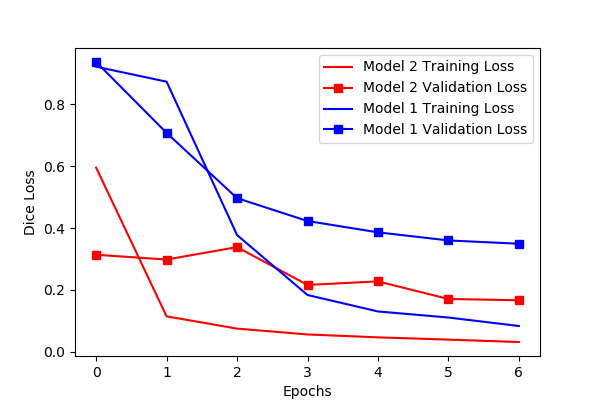

In [29]:
# Plot the results, including the previous ones
# Use different colors for the first and second model
plt.figure(figsize=(6.0, 4.0));
plt.plot(hist2.epoch,hist2.history['loss'],'r-')
plt.plot(hist2.epoch,hist2.history['val_loss'],'r-s')
plt.plot(hist.epoch,hist.history['loss'],'b-')
plt.plot(hist.epoch,hist.history['val_loss'],'b-s')
plt.legend(['Model 2 Training Loss',
            'Model 2 Validation Loss',
            'Model 1 Training Loss',
            'Model 1 Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.show()

##### Question 5: How can the validation loss be lower than the training loss?

<IPython.core.display.Javascript object>


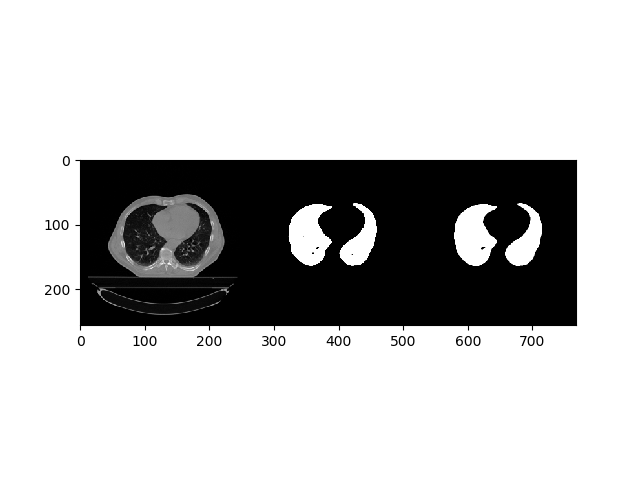

In [30]:
# Get the predictions of the new model
predictions2 = SegModel2.predict(x_val)
# display image with mask like before
disp_ind = 45
image = x_val[disp_ind,...,0]
predicted_mask = predictions2[disp_ind,...,0]
truth_mask = y_val[disp_ind,...,0]
# normalize image for display
image = image-np.min(image)
image = image/np.max(image)
# create a figure
plt.figure()
# combine images together into one
disp = np.c_[image,predicted_mask,truth_mask]
# display image
plt.imshow(disp,cmap='gray')
plt.show()

It's better! The network learned much faster, as is apparent in the loss plots. The new model also already has better overall results. Additionally, the mask has more fine detail than the previous version without skip connections. Having these skip connections definitely make a difference. The difference becomes more pronounced for deeper networks (more layers) with more parameters and larger images.

To get a complete idea of the performance of the model, we can scroll through the entire validation set and see all the different masks it generated.

<IPython.core.display.Javascript object>


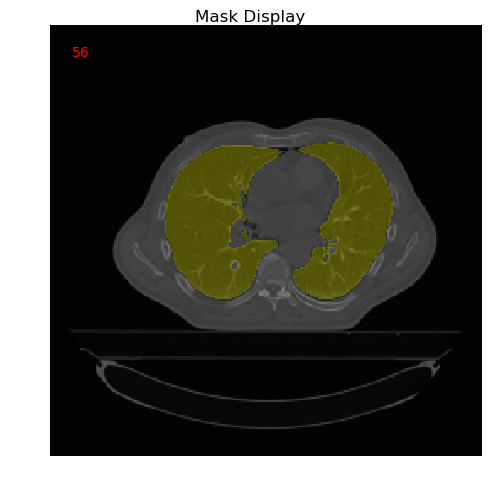

In [31]:
from Demo_Functions import mask_viewer

images = np.copy(x_val[...,0])
masks = predictions2[...,0]
mask_viewer(images,masks)

Now that you know the functional API, you can make any graph you like, train it, and use it! Once you've mastered the syntax and conceptual understanding of how to connect layers, you are only limited by your imagination as far as what kind of network you can build.

## End of Segmentation Example. Happy deep learning!

## Answers to Questions
#### 1- What other choices could we make for input image normalization?

You can really normalize any way you want. Some other typical methods are normalizing to the ranges [0,1] or [-1,1]. Since these are CT images we could take advanteage of Hounsfield Units and scale water to be 0, air to be -1, etc. The import thing is that the data is fed into the model in a consistent way.
    
    
#### 2- What could be another use for having multiple input channels?

In MRI, multiple sequences are usually acquired. It might take some resampling of the data, but you could use multiple sequences as different channels, for example, T1, T2, and 2-point Dixon images. Including more channels in your inputs almost always results in better performance for a deep learning model.

#### 3- What techniques or strategies can be used to mitigate issues with overfitting?

The best solution is to use more data. That is rarely a possible solution in medical imaging, so there are some alternatives.
1. Use data augmentation to synthesize extra data
2. Reduce the size or complexity of the network
3. Introduce regularization. This can include dropout, batch normalization, or L1/L2 regularization

#### 4- Can you explain the errors made by the deep learning model?

No! It's really difficult to explain or understand exactly what is going on inside a CNN. There's simply too many parameters involved to be able to pick apart what each one is doing. That's why training always needs validation- it's the only way to check that our model is really learning something useful.

#### 5- How can the validation loss be lower than the training loss?

It generally isn't, because the model learns from the training data and not the validation data. Only in contrived scenarios could the model actually perform better on the validation data than training. However, sometimes you will see lower validation loss. The explanations could be:
* The model has equivalent performance on training and validation, and slight random differences make the validation loss slightly lower
* A quirk of Keras. This is how Keras evaluates losses during training:
    1. Calculate loss of each training batch during epoch
    2. Average these losses together at end of epoch. This is the epoch's training loss
    3. Calculate total validation loss at end of epoch.
    
If a model learns very quickly (frequent in the first few epochs) then the performance of the model at the end of the epoch, when it evaluates the validation data, will better than the average performance during the entire epoch.